In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import io
from PIL import Image

# Rapidly Exploring Tree Star (RRT*)

### Define Node Class
* variables : position, parent(previous node), cost
* methods : 
    * \- (sub) : calculate euclidean distance
    * repr : print node information
    * show : visualize node position

In [18]:
import numpy.linalg as LA
class Node():
    def __init__(self, position, parent=None):
        self.position = np.array(position)
        self.parent = parent
        self.cost = 0
        
    def __sub__(self, other):
        return LA.norm(self.position - other.position)
    
    def __repr__(self):
        return 'pos:{0}'.format(self.position)
    
    def show(self, **kwargs):
        plt.gca().scatter(self.position[0], self.position[1], **kwargs)
        plt.xlim([0,10])
        plt.ylim([0,10])

### Define RRT* Algorithm Class
* variables : 
    * new_node_dist : step length for new node 
    * smpl_area : map area for RRT
    * obstacles : circular obstacles informations
* methods : 
    * get_rnd_node : select random point(node) in smpl_area
    * is_goal : goal node detection using euclidean distance
    * is_collision : collision detection using euclidean distance
    * is_in_area : check if node is in area
    * find_nearest_node : find nearest node in tree
    * fine_neighbor_nodes : find neighbor node of new_node by distance

In [19]:
class RRTstarAlg():
    def __init__(self, start=None, end=None, new_node_dist=0.5, smpl_area=[0,10,0,10], obstacles=None):
        self.start = start
        self.end = end
        self.new_node_dist = new_node_dist
        self.smpl_area = smpl_area # [xmin, xmax, ymin, ymax]
        self.obstacles = obstacles
        self.tree = [self.start]
    
    def get_rnd_point(self):
        rnd_pos = np.array([random.uniform(*self.smpl_area[0:2]),
                            random.uniform(*self.smpl_area[2:])])
        return Node(rnd_pos)

    def is_goal(self, node, margin=0.5):
        if node-self.end < margin:
            return True
        return False
    
    def is_collision(self, node, margin):
        for obs in self.obstacles:
            obs_pos = np.array(obs[:2])
            obs_radius = obs[2]
            distance = LA.norm(node.position - obs_pos) - obs_radius - margin
            if distance < 0:
                return True
        return False
    
    def is_in_area(self, node):
        xpos, ypos = node.position
        is_in_xarea = (self.smpl_area[0] < xpos) & (xpos < self.smpl_area[1])
        is_in_yarea = (self.smpl_area[2] < ypos) & (ypos < self.smpl_area[3])
        return is_in_xarea & is_in_yarea
    
    def find_nearest_node(self, rnd_node):
        distances = [rnd_node-node for node in self.tree]
        minidx = distances.index(min(distances))
        return self.tree[minidx]
    
    def find_neighbor_nodes(self, new_node, dist=1):
        neighbor_list = []
        for i,node in enumerate(self.tree):
            if (new_node - node) < dist:
                neighbor_list.append((i, node))
        return neighbor_list

        

### RRT Class : RRT Algorithm + Visualization

In [40]:
class RRT(RRTstarAlg):
    
    def show(self):
        self.plot_tree()
        self.plot_obstacles()
        self.start.show(color='r', label='start')
        self.end.show(color='b', label='goal')
        self.plot_final_path()
        
    def plot_tree(self):
        ax = plt.gca()
        for node in self.tree:
            if node.parent:
                pts = np.array([node.position, node.parent.position])
                ax.plot(*pts.T, color='k')
        return ax
    
    def plot_obstacles(self):
        ax = plt.gca()
        for obs in self.obstacles:
            c = mpatches.Circle(obs[:2], obs[2], fc='k')
            im = ax.add_artist(c)
        return im
    
    def plot_final_path(self):
        if not 'goal_node' in dir(self):
            return False
        
        ax = plt.gca()
        temp_node = self.goal_node
        while temp_node.parent:
            pts = np.array([temp_node.position, temp_node.parent.position])
            im = ax.plot(*pts.T, color='r')
            temp_node = temp_node.parent
        return im
    
    def make_snapshot(self):
        buffer = io.BytesIO()        
        fig = plt.figure()
        rrt.show()
        plt.savefig(buffer, format='png')
        buffer.seek(0)
        im = Image.open(buffer)
        plt.close(fig)
        return im

    


### Initialization

In [41]:
#init
start_node = Node([5,5])
end_node = Node([1,0.5])
smpl_area = [0,10,0,10]
obstacles = [(4,8,1), (6,4,1), (3,3,1)]

rrt = RRT(start_node, end_node, new_node_dist=0.5, smpl_area=smpl_area, obstacles=obstacles)

## Search 
* 'rec' for recording path search
* Loop : 
    * Get Random Point in area
    * Find nearest node in tree
    * Calculate distance vector from the nearest node to the random point
    * Calculate new node : vector of (new_node_len) * (distance vector)
    * check collision and goal. if not, add to tree

In [42]:
max_iter = 500
ims = []

for it in range(max_iter):
    rnd_node = rrt.get_rnd_point()
    nearest_node = rrt.find_nearest_node(rnd_node)
    distance = (rnd_node.position - nearest_node.position)
    new_node_pos = nearest_node.position + distance/LA.norm(distance) * rrt.new_node_dist
    new_node = Node(new_node_pos, parent=nearest_node)
    nbrs = rrt.find_neighbor_nodes(new_node, dist=1)
    
    nbr_cost_list = [nbr.cost + (nbr-new_node) for (i,nbr) in nbrs]
    lowest_cost_idx = nbr_cost_list.index(min(nbr_cost_list))
    new_node.parent = nbrs[lowest_cost_idx][1]
    new_node.cost = nbr_cost_list[lowest_cost_idx]
    
    # collision check
    if not rrt.is_collision(new_node, margin=0.1) & rrt.is_in_area(new_node):
        rrt.tree.append(new_node)
    else:
        continue
        
    #rewire
    for (idx, node) in nbrs:
        if node.cost > new_node.cost + (new_node - node):
            rrt.tree[idx].parent = rrt.tree[-1]
        
    # make snapshot for visualization
    im = rrt.make_snapshot()
    ims.append(im)
    
    if rrt.is_goal(new_node):
        print('goal')
        rrt.goal_node = new_node
        print(it)
        break


goal
308


### Reconstruct Path
*   goal - goal.parent - goal.parent.parent - ...

In [39]:
%matplotlib inline

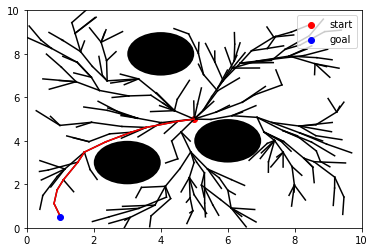

In [46]:
fig, ax = plt.subplots()
rrt.show()
plt.legend(loc='upper right');

# make snapshot for visualization
im = rrt.make_snapshot()
ims.append(im)

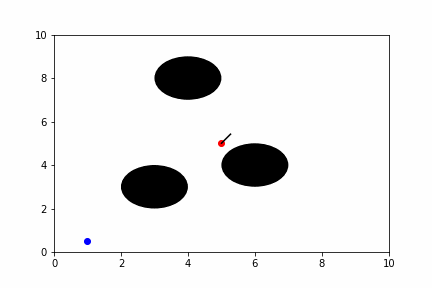

In [51]:
from IPython.display import Image
Image(filename="out.gif")

### Visualization 

In [50]:
ims = ims + [ims[-1]]*30
ims[0].save('out.gif', format='GIF',
               append_images=ims[1:],
               save_all=True,
               duration=10, loop=0)